In [18]:
#!/usr/bin/env python3
import uproot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import awkward as ak
import seaborn as sns

# Configuration for testing vs production
TESTING_MODE = True  # Set to False for full analysis
MAX_EVENTS = 10000 if TESTING_MODE else None  # None means read all events
print(f"Running in {'TESTING' if TESTING_MODE else 'PRODUCTION'} mode")
# Load the ROOT files and access the trees
HZ4Lep = uproot.open("Bg1_hz.root")
ZWW4Lep = uproot.open("Bg2_zww.root")
HZ4LepLFV = uproot.open("Sn1_hzLFV.root")
HZ4Lep_tree = HZ4Lep["Delphes"]
ZWW4Lep_tree = ZWW4Lep["Delphes"]
HZ4LepLFV_tree = HZ4LepLFV["Delphes"]

# Check for events with exactly 4 leptons
column_arrays = ["MissingET_size","MissingET.Eta","MissingET.Phi","MissingET.MET",
                 "Jet_size",
                 "Electron_size","Electron.Eta","Electron.Phi","Electron.PT",
                 "Muon_size","Muon.Eta","Muon.Phi","Muon.PT"]
HZ4Lep_array = HZ4Lep_tree.arrays(column_arrays,  entry_stop=MAX_EVENTS)
ZWW4Lep_array = ZWW4Lep_tree.arrays(column_arrays,  entry_stop=MAX_EVENTS)
HZ4LepLFV_array = HZ4LepLFV_tree.arrays(column_arrays, entry_stop=MAX_EVENTS)

Running in TESTING mode


In [22]:
def check_jet(jet_array,name):
    fig=plt.figure()
    ax=fig.add_subplot(111)
    ax.hist(jet_array, bins=10, range=(-0.5, 9.5))
    ax.set_title(f"Jet Size Distribution - {name}")
    ax.set_xlabel("Jet Size")
    ax.set_ylabel("Count")
    plt.savefig(f"JetSize_{name}.png")
    plt.close()
    return 1

def check_lepton(Earray, Muarray, name, mask):
    fig=plt.figure()
    ax=fig.add_subplot(111)
    ax.hist(Earray[mask] + Muarray[mask], bins=10, range=(-0.5, 9.5))
    ax.set_title(f"Lepton Size Distribution - {name}")
    ax.set_xlabel("Lepton Size")
    ax.set_ylabel("Count")
    plt.savefig(f"LeptonSize_{name}.png")
    plt.close()
    return 1

def finalstate_fourlepton_cut(name,Earray,Muarray):
    mask = (Earray + Muarray == 4)
    print(f"    {name}:{np.sum(mask)}/{len(mask)} : {np.sum(mask)/len(mask)*100:.2f}%")
    return mask

def check_MET_distribution(array,name):
    fig=plt.figure()
    ax=fig.add_subplot(111)
    ax.hist(array["MissingET_size"], bins=10, range=(-0.5, 9.5))
    ax.set_title(f"MET_size Distribution - {name}")
    ax.set_xlabel("MET_size")
    ax.set_ylabel("Count")
    plt.savefig(f"MET_size_{name}.png")
    plt.close()
    return 1

def check_drFromMET(n_array, name):
    # Calculate delta R between MET and each lepton
    print(f"Calculating Delta R from MET to Leptons for {name}...")
    fig=plt.figure()
    ax=fig.add_subplot(111)
    ax.set_title(f"Delta R from MET to Leptons - {name}")
    ax.set_xlabel("Delta R")
    ax.set_ylabel("Count")
    deta_r=np.array([])
    total_events = len(n_array["MissingET_size"])
    for number_event in range(total_events):
        enum=n_array["Electron_size"][number_event]
        for ie in range(enum):
            dphi=n_array["Electron.Phi"][number_event][ie]-n_array["MissingET.Phi"][number_event]
            while (dphi > np.pi):
                dphi -= 2*np.pi
            while (dphi < -np.pi):
                dphi += 2*np.pi
            dr=np.sqrt((n_array["Electron.Eta"][number_event][ie]-n_array["MissingET.Eta"][number_event])**2 + dphi**2)
            deta_r=np.append(deta_r, dr)
        mnum=n_array["Muon_size"][number_event]
        for im in range(mnum):
            dphi=n_array["Muon.Phi"][number_event][im]-n_array["MissingET.Phi"][number_event]
            while (dphi > np.pi):
                dphi -= 2*np.pi
            while (dphi < -np.pi):
                dphi += 2*np.pi
            dr=np.sqrt((n_array["Muon.Eta"][number_event][im]-n_array["MissingET.Eta"][number_event])**2 + dphi**2)
            deta_r=np.append(deta_r, dr)
        
        print(f"Finished event {(number_event+1)/total_events*100:.2f}%", end='\r')
            
    ax.hist(deta_r, bins=100, range=(0, 5))

    plt.savefig(f"DeltaR_MET_Leptons_{name}.png")
    plt.close()
    return 1

In [30]:
def PT_distribution(arr1,arr2,arr3,name):
    fig=plt.figure()
    ax=fig.add_subplot(111)
    # ax.hist(ak.flatten(arr1["Electron.PT"]), bins=120, range=(0, 240))
    sns.histplot(ak.flatten(arr1["Electron.PT"]), bins=120, binrange=(0, 240), ax=ax)
    ax.set_title(f"Electron PT :{name}")
    ax.set_xlabel("Electron PT")
    ax.set_ylabel("Count")
    plt.savefig(f"figure/test/Electron_PT_{name}.png")
    plt.show()
    plt.close()
    return 1

FileNotFoundError: [Errno 2] No such file or directory: 'figure/test/Electron_PT_HZ4Lep.png'

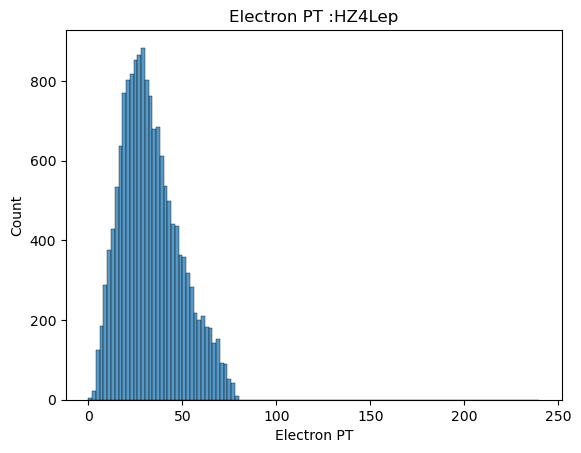

In [31]:
PT_distribution(HZ4Lep_array,ZWW4Lep_array,HZ4LepLFV_array,"HZ4Lep")

In [21]:
print("Analyzing ratio of Events with exactly 4 leptons...")
HZ4Lep_4lcut=finalstate_fourlepton_cut("HZ4Lep", HZ4Lep_array["Electron_size"], HZ4Lep_array["Muon_size"])
ZWW4Lep_4lcut=finalstate_fourlepton_cut("ZWW4Lep", ZWW4Lep_array["Electron_size"], ZWW4Lep_array["Muon_size"])
HZ4LepLFV_4lcut=finalstate_fourlepton_cut("HZ4LepLFV", HZ4LepLFV_array["Electron_size"], HZ4LepLFV_array["Muon_size"])

Analyzing ratio of Events with exactly 4 leptons...
    HZ4Lep:5867/10000 : 58.67%
    ZWW4Lep:5893/10000 : 58.93%
    HZ4LepLFV:6605/10000 : 66.05%


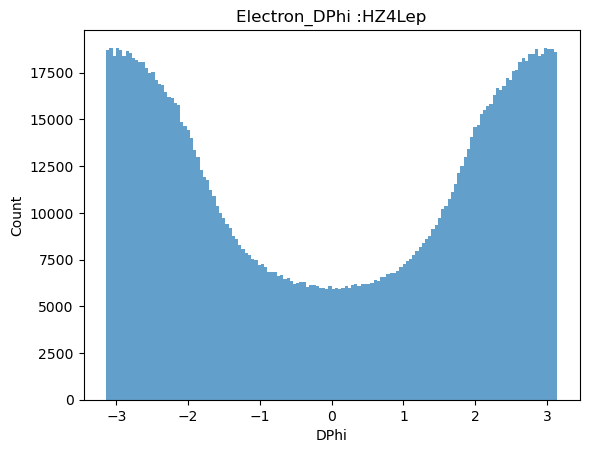

In [14]:
def simple_phiDiffplot(array,name):
    n_array = ak.flatten(array)
    n_array = (n_array + np.pi) % (2 * np.pi) - np.pi  
    fig=plt.figure()
    ax=fig.add_subplot(111)
    ax.hist(n_array, bins=140, alpha=0.7, range=(-np.pi, np.pi))
    ax.set_title(f"Electron_DPhi :{name}")
    ax.set_xlabel("DPhi")
    ax.set_ylabel("Count")
    plt.show()
    plt.close()

simple_phiDiffplot(ak.firsts(HZ4Lep_array["MissingET.Phi"])-HZ4Lep_array["Electron.Phi"],"HZ4Lep")